In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelpdata1/yelp.csv


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [6]:
#Import the data, used Kaggle
yelpdata = pd.read_csv('../input/yelpdata1/yelp.csv')
yelpdata.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [7]:
#Shape of yelp data
yelpdata.shape

(10000, 10)

In [8]:
#Describe yelp data
yelpdata.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


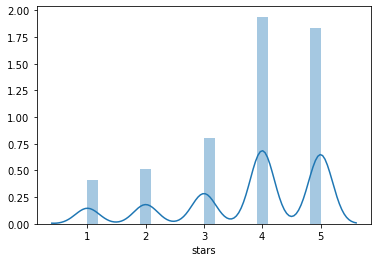

In [9]:
sns.distplot(yelpdata["stars"])

In [10]:
#Look at counts of people who gave star ratings, 3526 people gave 4 star ratings
yelpdata["stars"].value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

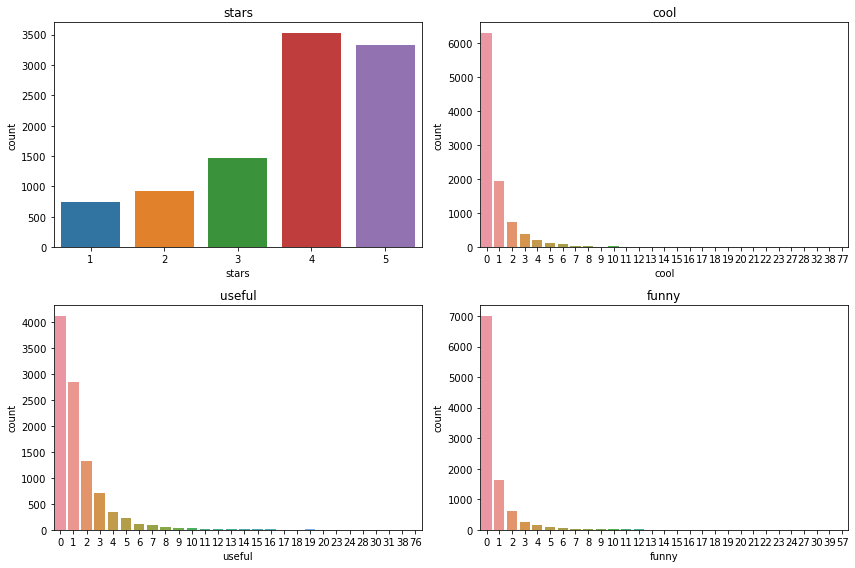

In [11]:
#Plot the voting columns, star rating, cool rating, useful rating, funny rating
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(12,8))
axes1 = plt.subplot(2,2,1)
axes1 = sns.countplot(x='stars', data=yelpdata)
axes1.set_title('stars')
axes1.set_ylabel('count')

axes2 = plt.subplot(2,2,2)
axes2 = sns.countplot(x='cool', data=yelpdata)
axes2.set_title('cool')
axes2.set_ylabel('count')

axes3 = plt.subplot(2,2,3)
axes3 = sns.countplot(x='useful', data=yelpdata)
axes3.set_title('useful')
axes3.set_ylabel('count')

axes4 = plt.subplot(2,2,4)
axes4 = sns.countplot(x='funny', data=yelpdata)
axes4.set_title('funny')
axes4.set_ylabel('count')

plt.tight_layout()

Text(0.5, 1.0, 'Heatmap of Variables')

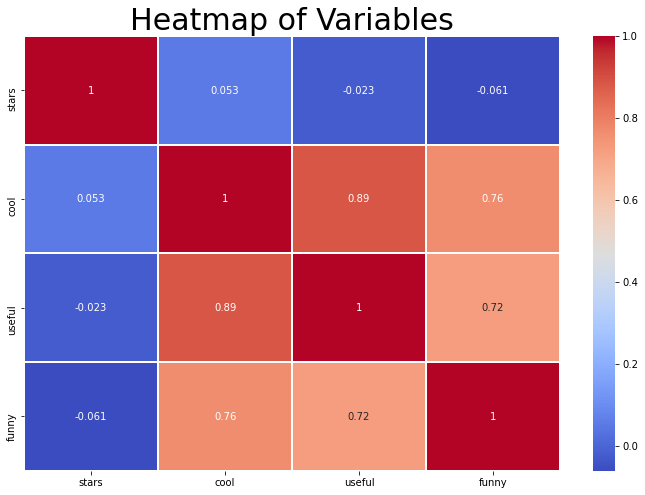

In [12]:
#Plot a correlation heat map of the voter ratings
#Can see not much correlations, so analysis of textual data (i.e., customer reviews) would be more helpful
yelp_cor = yelpdata[['stars', 'cool', 'useful', 'funny']].corr()

fig = plt.figure(figsize=(12,8))
axes = sns.heatmap(yelp_cor, cmap='coolwarm', linewidth=1, linecolor='white', annot=True)
axes.set_title('Heatmap of Variables', fontsize=30)

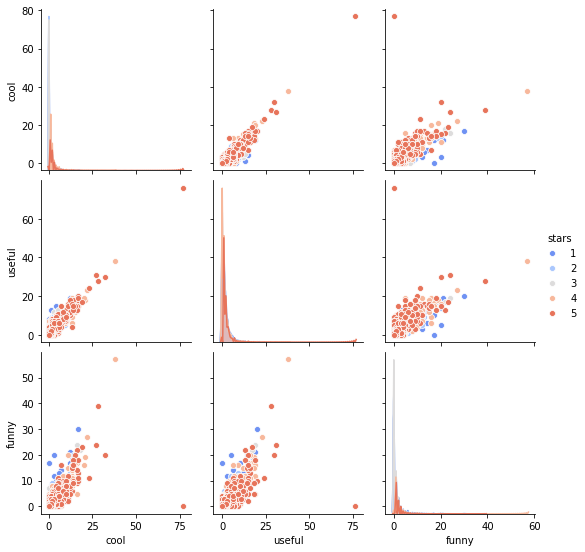

In [13]:
sns.pairplot(yelpdata, hue='stars', palette='coolwarm')

In [14]:
#The heatmap, pairplot and boxplot verify that those other numerical variables cannot be used to predict 'Stars'. Therefore, we have to focus on text analysis.

In [15]:
#Create a new dataframe only with stars and text; stars column renamed to label and text renamed to
#feature
yelpclassdata = yelpdata.rename(columns = {"stars":"label","text":"feature"})
yelpclassdata.head()

,business_id,date,review_id,label,feature,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [16]:
#Take only the columns 'feature' and 'label' from the data
yelpclassdata = yelpclassdata[['feature', 'label']]
yelpclassdata.head(5)

,feature,label
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,love the gyro plate. Rice is so good and I als...,4
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,General Manager Scott Petello is a good egg!!!...,5


# **Tokenization of sentences and generating the words**

In [17]:
#In order to produce a confusion matrix by applying a Naive Bayes NLP need to filter 
#stars into 5 and 1
#yelpclassdata = yelpclassdata[(yelpclassdata["label"]==5) | (yelpclassdata["label"]==1)]
#yelpclassdata.shape

In [18]:
# examine the class distribution
yelpclassdata.label.value_counts().sort_index()

1     749
2     927
3    1461
4    3526
5    3337
Name: label, dtype: int64

In [19]:
#Tokenization with Regrex, without NLTK
from nltk.corpus import stopwords
import re

word_list=[]

i = 0

#iterating through each text
for txt in yelpclassdata['feature']:

    #splits txt into words, drop any non-alphabet characters
    w_list = re.sub(r'[^a-z]',' ', txt.lower()).split()
    
    #add another column with tokens of that text as features
    yelpclassdata.loc[i,'feature1'] = ' '.join(w_list)
    
    #Remove stopwords from w_list #If in there don't include it; English function has a list of stop words
    w_list = [w for w in w_list if w not in stopwords.words('english')]
    
    #List of all the tokens without stopwords
    word_list += w_list
    
    #Incrementing the index variable
    i += 1

yelpclassdata.head()

,feature,label,feature1
0,My wife took me here on my birthday for breakf...,5,my wife took me here on my birthday for breakf...
1,I have no idea why some people give bad review...,5,i have no idea why some people give bad review...
2,love the gyro plate. Rice is so good and I als...,4,love the gyro plate rice is so good and i also...
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5,rosie dakota and i love chaparral dog park it ...
4,General Manager Scott Petello is a good egg!!!...,5,general manager scott petello is a good egg no...


In [21]:
#From INFO70041 Jupyter walkthrough
#Get frequency distribution of words
all_words_fd =nltk.FreqDist(word_list)
#Get most common 3000 of them and store in word_common
word_common = all_words_fd.most_common(3000)
#Store word_features as the first element in thecouple
word_features = [w[0] for w in word_common]

print(word_common[0:5])
print(word_features)

[('good', 6801), ('place', 6662), ('food', 6184), ('great', 5127), ('like', 5041)]
['good', 'place', 'food', 'great', 'like', 'one', 'get', 'go', 'time', 'really', 'service', 'would', 'back', 'also', 'love', 'little', 'nice', 'well', 'always', 'even', 'best', 'us', 'got', 'pretty', 'much', 'restaurant', 'chicken', 'try', 'ordered', 'menu', 'people', 'first', 'know', 'bar', 'order', 'could', 'think', 'better', 'never', 'friendly', 'make', 'went', 'staff', 'night', 'way', 'going', 'cheese', 'pizza', 'right', 'two', 'delicious', 'made', 'came', 'say', 'want', 'salad', 'lunch', 'come', 'new', 'day', 'fresh', 'sauce', 'still', 'take', 'eat', 'see', 'experience', 'since', 'sure', 'definitely', 'happy', 'around', 'wait', 'something', 'times', 'ever', 'next', 'find', 'everything', 'every', 'amazing', 'bit', 'though', 'give', 'meal', 'area', 'said', 'bad', 'table', 'many', 'location', 'dinner', 'thing', 'lot', 'hour', 'last', 'another', 'phoenix', 'side', 'small', 'big', 'prices', 'home', 'favo

# Using countvectorizer for representation of features and then applying Skitlearn with Multimonial NB

In [22]:
#Define X and y
#Pass in tokenized words into X
X = yelpclassdata["feature1"]
y = yelpclassdata["label"]

In [24]:
# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state = 101)

In [25]:
# Examine the object shapes
print(X_train.shape)
print(X_test.shape)

(7000,)
(3000,)


In [26]:
# Use CountVectorizer to create document-term matrices from X_train and X_test
# Acts as a form of tokenizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect

CountVectorizer()

In [27]:
# Fit and transform X_train
X_train = vect.fit_transform(X_train)
X_train

<7000x24029 sparse matrix of type '<class 'numpy.int64'>'
	with 571240 stored elements in Compressed Sparse Row format>

In [28]:
# Transform X_test
X_test = vect.transform(X_test)

In [29]:
# Examine the shapes
print(X_train.shape)
print(X_test.shape)

(7000, 24029)
(3000, 24029)


In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [34]:
# Print the number of generated features for the training set
print('Features: ', X_train.shape[1])

# To predict the star rating use Multimonial NB
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred_class = model.predict(X_test)

#Print Actual and Predicted values for star rating
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_class})
df

Features:  24029


,Actual,Predicted
6676,3,3
6421,4,4
9834,5,5
8492,5,5
9982,4,4
...,...,...
372,5,4
8015,5,5
6474,4,4
6071,5,4


In [32]:
# Print the accuracy of its predictions
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

# Print the confusion matrix
print('Confusion Matrix: ')
print(metrics.confusion_matrix(y_test, y_pred_class))

Accuracy:  0.4826666666666667
Confusion Matrix: 
[[ 68  34  13  74  31]
 [ 16  21  42 162  32]
 [  5  11  42 341  44]
 [  7   3  24 765 265]
 [  6   2   6 434 552]]


In [33]:
#Print the classification report
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.67      0.31      0.42       220
           2       0.30      0.08      0.12       273
           3       0.33      0.09      0.15       443
           4       0.43      0.72      0.54      1064
           5       0.60      0.55      0.57      1000

    accuracy                           0.48      3000
   macro avg       0.46      0.35      0.36      3000
weighted avg       0.48      0.48      0.45      3000

